In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt


# Import Dataset Hasil Pre-Processing

In [4]:
# --- Konfigurasi Jalur Dataset yang Sudah Diproses ---
processed_base_path = '../data/processed/' # Lokasi folder 'processed'
TRAIN_DIR = os.path.join(processed_base_path, 'train')
VAL_DIR = os.path.join(processed_base_path, 'val')
TEST_DIR = os.path.join(processed_base_path, 'test')

# Ukuran gambar yang sudah diproses (harus sama dengan TARGET_IMAGE_SIZE di pra-pemrosesan awal)
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
TARGET_IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

# One Hot Encoding

In [5]:
# --- Pada fungsi load_split_data(directory) ---
def load_split_data(directory):
    images = []
    labels_raw = []
    
    # Asumsi: _annotations.csv ada di setiap folder split
    annotations_path = os.path.join(directory, '_annotations.csv') # <--- Di sini path ke _annotations.csv dibuat di dalam folder split
    
    # --- PENTING: Pastikan file _annotations.csv ada ---
    if not os.path.exists(annotations_path):
        print(f"Error: File '{annotations_path}' tidak ditemukan. Tidak dapat memuat data dari '{directory}'.")
        # Mengembalikan array kosong jika file anotasi tidak ditemukan
        return np.array([]), np.array([]) 

    df_annotations = pd.read_csv(annotations_path) # <--- Membaca CSV dari folder split tersebut
    
    print(f"Memuat {len(df_annotations)} gambar dari '{directory}' menggunakan '{annotations_path}'...")
    
    for idx, row in df_annotations.iterrows():
        filename = row['filename']
        # --- MENGAMBIL CLASS DARI KOLOM 'class' DI CSV ---
        class_label = row['class'] # <--- Mengambil label dari kolom 'class' di CSV
        # --- AKHIR BAGIAN YANG RELEVAN ---
        
        img_path = os.path.join(directory, filename) # <--- Path gambar juga dibuat di dalam folder split
        
        try:
            img = Image.open(img_path).convert('RGB')
            img_array = np.array(img) / 255.0 # Normalisasi ke 0-1
            images.append(img_array)
            labels_raw.append(class_label) # Simpan label mentah dari CSV
        except FileNotFoundError:
            print(f"Peringatan: Gambar '{img_path}' tidak ditemukan. Melewati.")
        except Exception as e:
            print(f"Peringatan: Error memuat gambar '{img_path}': {e}. Melewati.")

    return np.array(images), np.array(labels_raw)

In [6]:
from PIL import Image
# Muat data untuk setiap split
X_train, y_train_raw = load_split_data(TRAIN_DIR)
X_val, y_val_raw = load_split_data(VAL_DIR)
X_test, y_test_raw = load_split_data(TEST_DIR)

# Periksa apakah ada data yang berhasil dimuat sebelum melanjutkan
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    print("\nError: Salah satu atau semua dataset kosong. Pastikan file _annotations.csv dan gambar ada di lokasi yang benar.")
    # Anda bisa memilih untuk menghentikan eksekusi di sini jika data tidak dimuat
    # import sys
    # sys.exit()

print(f"\nDataset training dimuat. Bentuk X_train: {X_train.shape}, y_train_raw: {y_train_raw.shape}")
print(f"Dataset validation dimuat. Bentuk X_val: {X_val.shape}, y_val_raw: {y_val_raw.shape}")
print(f"Dataset test dimuat. Bentuk X_test: {X_test.shape}, y_test_raw: {y_test_raw.shape}")


Memuat 943 gambar dari '../data/processed/train' menggunakan '../data/processed/train\_annotations.csv'...
Memuat 118 gambar dari '../data/processed/val' menggunakan '../data/processed/val\_annotations.csv'...
Memuat 118 gambar dari '../data/processed/test' menggunakan '../data/processed/test\_annotations.csv'...

Dataset training dimuat. Bentuk X_train: (943, 224, 224, 3), y_train_raw: (943,)
Dataset validation dimuat. Bentuk X_val: (118, 224, 224, 3), y_val_raw: (118,)
Dataset test dimuat. Bentuk X_test: (118, 224, 224, 3), y_test_raw: (118,)


In [7]:
# --- Encoding Label ---
# Gabungkan semua label mentah dari semua split untuk memastikan LabelEncoder melihat semua kelas
all_raw_labels = np.concatenate((y_train_raw, y_val_raw, y_test_raw))
label_encoder = LabelEncoder()
label_encoder.fit(all_raw_labels)

# Sekarang ubah label mentah menjadi integer encoded
y_train_encoded_int = label_encoder.transform(y_train_raw)
y_val_encoded_int = label_encoder.transform(y_val_raw)
y_test_encoded_int = label_encoder.transform(y_test_raw)

# Kemudian, lakukan One-Hot Encoding
NUM_CLASSES = len(label_encoder.classes_)
onehot_encoder = OneHotEncoder(sparse_output=False)
# Fit OneHotEncoder dengan semua kemungkinan integer encoded label
onehot_encoder.fit(np.arange(NUM_CLASSES).reshape(-1, 1))

y_train = onehot_encoder.transform(y_train_encoded_int.reshape(-1, 1))
y_val = onehot_encoder.transform(y_val_encoded_int.reshape(-1, 1))
y_test = onehot_encoder.transform(y_test_encoded_int.reshape(-1, 1))

print(f"\nLabel training setelah One-Hot Encoding: {y_train.shape}")
print(f"Label validation setelah One-Hot Encoding: {y_val.shape}")
print(f"Label test setelah One-Hot Encoding: {y_test.shape}")
print(f"Jumlah kelas yang teridentifikasi: {NUM_CLASSES}")
print(f"Nama kelas: {label_encoder.classes_}")


Label training setelah One-Hot Encoding: (943, 2)
Label validation setelah One-Hot Encoding: (118, 2)
Label test setelah One-Hot Encoding: (118, 2)
Jumlah kelas yang teridentifikasi: 2
Nama kelas: ['Anorganik' 'Organik']


# Augmentasi

In [8]:
BATCH_SIZE = 32 # Ukuran batch untuk generator

datagen_train_augmented = ImageDataGenerator(
    rotation_range=180,        # Rotasi gambar secara acak hingga 20 derajat
    width_shift_range=0.2,    # Geser gambar secara horizontal hingga 20% dari lebar
    height_shift_range=0.2,   # Geser gambar secara vertikal hingga 20% dari tinggi
    shear_range=0.2,          # Geser geser (shear transformation)
    zoom_range=0.4,           # Perbesar atau perkecil gambar secara acak
    horizontal_flip=True,     # Balik gambar secara horizontal secara acak
    fill_mode='nearest'       # Strategi pengisian piksel yang baru dibuat
)



ImageDataGenerators untuk augmentasi telah disiapkan.


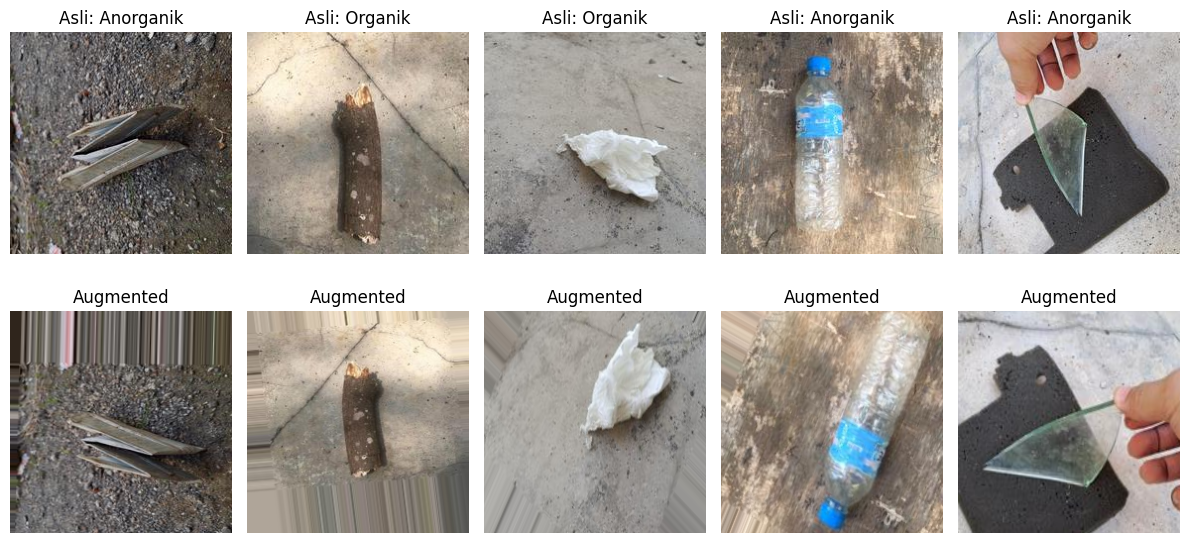

In [9]:
datagen_val_test = ImageDataGenerator() # Tidak ada augmentasi, hanya rescaling jika diperlukan (sudah dilakukan)

print("\nImageDataGenerators untuk augmentasi telah disiapkan.")

plt.figure(figsize=(12, 6))
for i, (original_image, original_label_onehot) in enumerate(zip(X_train[:5], y_train[:5])):
    # Gambar Asli
    plt.subplot(2, 5, i + 1)
    plt.imshow(original_image)
    # Konversi one-hot kembali ke nama kelas untuk judul
    original_class_name = label_encoder.inverse_transform([np.argmax(original_label_onehot)])[0]
    plt.title(f"Asli: {original_class_name}")
    plt.axis('off')

    # Hasilkan satu gambar yang diaugmentasi
    # `flow` mengharapkan input dalam bentuk batch, jadi kita perlu expand_dims
    augmented_image = next(datagen_train_augmented.flow(np.expand_dims(original_image, 0), batch_size=1))[0]
    
    # Gambar yang Diaugmentasi
    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_image)
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Callback

In [10]:
# --- Tambahkan inisialisasi callback EarlyStopping ini ---
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metrik yang akan dipantau
    mode='max',              # Kita ingin memaksimalkan val_accuracy
    patience=3,              # Berapa epoch menunggu setelah tidak ada peningkatan
    restore_best_weights=True, # Mengembalikan bobot model dari epoch terbaik
    verbose=1                # Menampilkan pesan ketika early stopping terjadi
)

# Custom callback untuk menghentikan training jika akurasi >= target
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.99):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')
        if acc is not None and acc >= self.target_accuracy:
            print(f"\nMencapai akurasi {acc:.2f}, menghentikan training.")
            self.model.stop_training = True

# Inisialisasi custom callback Anda (jika masih ingin menghentikan di 99% akurasi)
stop_at_99_accuracy_callback = StopAtAccuracy(target_accuracy=0.99)


# Bayesian Optimization (BO)

In [11]:
# --- Bagian 4: Definisikan Ruang Pencarian (Search Space) untuk Arsitektur CNN ---
def build_model(hp):
    """
    Fungsi untuk membangun model Keras dengan hyperparameter yang dapat di-tuning.
    Objek 'hp' (HyperParameters) disediakan oleh Keras Tuner.
    """
    model = keras.Sequential()

    # Jumlah Lapisan Konvolusional (Conv2D + MaxPooling blocks)
    # Keras Tuner akan memilih nilai integer dari rentang yang diberikan
    num_conv_blocks = hp.Int('num_conv_blocks', min_value=2, max_value=4, step=1)

    for i in range(num_conv_blocks):
        # Jumlah Filter untuk lapisan Conv2D
        # Keras Tuner akan memilih dari daftar nilai diskrit yang diberikan
        filters = hp.Choice(f'filters_{i}', values=[32, 64, 128, 256])
        
        # Ukuran Kernel: Dibiarkan tetap 3x3 untuk kesederhanaan, umum dan efektif
        kernel_size = (3, 3) 
        
        # Fungsi Aktivasi untuk lapisan konvolusional
        # Keras Tuner akan memilih dari daftar aktivasi yang diberikan
        activation_str = hp.Choice(f'activation_{i}', values=['relu', 'elu', 'leaky_relu'])
        
        # Tambahkan lapisan Conv2D
        # input_shape hanya perlu ditentukan pada lapisan pertama
        if activation_str == 'leaky_relu':
            # Untuk LeakyReLU, kita tambahkan lapisan LeakyReLU secara terpisah
            model.add(layers.Conv2D(filters, kernel_size, padding='same', 
                                    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3) if i == 0 else None))
            model.add(layers.LeakyReLU())
        else:
            # Untuk aktivasi lainnya, bisa langsung diberikan ke Conv2D
            model.add(layers.Conv2D(filters, kernel_size, activation=activation_str, padding='same', 
                                    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3) if i == 0 else None))
        
        # Ukuran Pooling: Umumnya 2x2 untuk downsampling
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten output dari lapisan konvolusional sebelum masuk ke lapisan dense
    model.add(layers.Flatten())

    # Jumlah Unit di Lapisan Dense (Fully Connected Layer)
    num_dense_units = hp.Int('num_dense_units', min_value=64, max_value=512, step=64)
    model.add(layers.Dense(num_dense_units))
    
    # Fungsi Aktivasi untuk lapisan Dense
    dense_activation_str = hp.Choice('dense_activation', values=['relu', 'elu'])
    # LeakyReLU untuk dense layer kurang umum tetapi bisa saja ditambahkan jika diperlukan.
    # Untuk kesederhanaan, hanya relu/elu yang ditawarkan di sini.
    model.add(layers.Activation(dense_activation_str))

    # Tingkat Dropout: Untuk regularisasi, mencegah overfitting
    # Keras Tuner akan memilih nilai float dari rentang yang diberikan
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    # Output Layer: Jumlah unit sesuai dengan jumlah kelas yang teridentifikasi (NUM_CLASSES)
    # Fungsi aktivasi 'softmax' untuk klasifikasi multi-kelas
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    # Optimizer: Memilih algoritma optimasi
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    
    # Learning Rate Optimizer: Laju pembelajaran, menggunakan skala logaritmik
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Inisialisasi optimizer berdasarkan pilihan
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else: # sgd
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    # Kompilasi model dengan optimizer, loss function (categorical_crossentropy untuk one-hot labels), dan metrics
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("Fungsi build_model (search space) telah didefinisikan.")

Fungsi build_model (search space) telah didefinisikan.


In [12]:

# Direktori untuk menyimpan log dan hasil pencarian Keras Tuner
LOG_DIR = '../models/keras_tuner'
os.makedirs(LOG_DIR, exist_ok=True) # Pastikan direktori ini ada

tuner = kt.BayesianOptimization(
    hypermodel=build_model,            # Fungsi hypermodel yang telah kita buat
    objective='val_accuracy',          # Tujuan optimasi: maksimalkan akurasi pada set validasi
    max_trials=20,                      # Jumlah total kombinasi hyperparameter yang akan diuji
                                       # Untuk pengujian awal/debug, gunakan nilai kecil seperti 10-20.
                                       # Untuk hasil yang lebih baik, pertimbangkan 50+ atau 100+ trial.
    executions_per_trial=1,            # Berapa kali setiap set hyperparameter akan dilatih
                                       # (meningkatkan ini mengurangi variansi, tetapi memperlambat pencarian)
    directory=LOG_DIR,                 # Direktori untuk menyimpan log pencarian
    project_name='klasifikasi_sampah_v2', # Nama proyek Anda
    overwrite=False
)

tuner.search_space_summary()


Reloading Tuner from ../models/keras_tuner\klasifikasi_sampah_v2\tuner0.json
Search space summary
Default search space size: 14
num_conv_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
filters_0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'leaky_relu'], 'ordered': False}
filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'leaky_relu'], 'ordered': False}
num_dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, '

In [13]:
# --- Bagian 6: Jalankan Pencarian (Search) ---

EPOCHS_PER_TRIAL = 10 

# Jalankan pencarian. Tambahkan `callbacks` yang diinginkan
tuner_callbacks = [
    early_stopping_callback,
    stop_at_99_accuracy_callback # Opsional: Gunakan ini jika Anda ingin kedua kondisi berlaku
]

tuner.search(datagen_train_augmented.flow(X_train, y_train, batch_size=BATCH_SIZE),
             epochs=EPOCHS_PER_TRIAL,
             validation_data=(X_val, y_val),
             callbacks=tuner_callbacks) # <--- Gunakan daftar callbacks di sini

print("\nPencarian Bayesian Optimization selesai.")


Pencarian Bayesian Optimization selesai.


In [14]:
# --- Bagian 7: Ambil Model Terbaik dan Tampilkan Ringkasan ---
best_models = tuner.get_best_models(num_models=1)
best_model = best_models[0]


d:\OneDrive\IBM Code Generations and Optimization\Capstone-Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\OneDrive\IBM Code Generations and Optimization\Capstone-Project\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Evaluasi Model BO

In [15]:
print("\nRingkasan Model Terbaik yang Ditemukan:")
best_model.summary()


Ringkasan Model Terbaik yang Ditemukan:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,535,842 (24.93 MB)

 Trainable params: 6,535,842 (24.93 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Evaluasi pada test set (menggunakan model hasil fine-tuning)
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test Loss setelah bayesian optimization: {loss:.4f}")
print(f"Final Test Accuracy setelah bayesian optimization: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.9583 - loss: 0.1553
Final Test Loss setelah bayesian optimization: 0.1396
Final Test Accuracy setelah bayesian optimization: 0.9661


# Save Best Model BO

In [17]:
# --- Simpan model terbaik setelah pelatihan ulang ---
MODEL_SAVE_PATH = '../models/klasifikasi_sampah_v1.h5' # Format HDF5

best_model.save(MODEL_SAVE_PATH)
print(f"\nModel terbaik telah disimpan ke: {MODEL_SAVE_PATH}")

# Contoh cara memuat kembali model:
# loaded_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
# print(f"Model berhasil dimuat kembali. Summary model yang dimuat:")
# loaded_model.summary()


Model terbaik telah disimpan ke: ../models/klasifikasi_sampah_v1.h5


# Fine-Tunning

In [18]:
# Ambil best hyperparameters dari tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nHyperparameter terbaik yang akan digunakan untuk Fine-Tuning:")
print(f"Jumlah blok konvolusional (custom head): {best_hps.get('num_conv_blocks')}")

for i in range(best_hps.get('num_conv_blocks')):
    print(f"  Blok {i+1} - Filters: {best_hps.get(f'filters_{i}')}, Aktivasi: {best_hps.get(f'activation_{i}')}")

print(f"Jumlah unit Dense: {best_hps.get('num_dense_units')}")
print(f"Aktivasi Dense: {best_hps.get('dense_activation')}")
print(f"Tingkat Dropout: {best_hps.get('dropout_rate')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Learning Rate (initial): {best_hps.get('learning_rate'):.6f}")



Hyperparameter terbaik yang akan digunakan untuk Fine-Tuning:
Jumlah blok konvolusional (custom head): 3
  Blok 1 - Filters: 64, Aktivasi: leaky_relu
  Blok 2 - Filters: 128, Aktivasi: leaky_relu
  Blok 3 - Filters: 32, Aktivasi: leaky_relu
Jumlah unit Dense: 256
Aktivasi Dense: relu
Tingkat Dropout: 0.4
Optimizer: rmsprop
Learning Rate (initial): 0.000183


In [19]:
# Bangun Model Dasar Pra-terlatih (Base Model)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), 
    include_top=False,
    weights='imagenet'
)

# Bekukan lapisan dasar
base_model.trainable = False

# Bangun Kepala Klasifikasi Kustom Menggunakan Hyperparameter Terbaik BO
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x) 

num_dense_units = best_hps.get('num_dense_units')
dense_activation = best_hps.get('dense_activation')
kernel_initializer_dense = best_hps.get('kernel_initializer_dense') if 'kernel_initializer_dense' in best_hps.values else 'glorot_uniform'
dropout_rate = best_hps.get('dropout_rate')

x = layers.Dense(num_dense_units, 
                 kernel_initializer=kernel_initializer_dense,
                 activation=dense_activation)(x)
x = layers.Dropout(dropout_rate)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

fine_tuned_model = keras.Model(inputs, outputs)

print("\nModel gabungan (Base Model + Custom Head dari BO) dibuat.")


Model gabungan (Base Model + Custom Head dari BO) dibuat.


In [20]:
print("Ringkasan Model Gabungan:")
fine_tuned_model.summary()

Ringkasan Model Gabungan:


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
# Kompilasi Model (Tahap 1: Hanya Kepala Kustom)
optimizer_choice_t1 = best_hps.get('optimizer')
learning_rate_t1 = best_hps.get('learning_rate')

optimizer_t1 = None
if optimizer_choice_t1 == 'adam':
    optimizer_t1 = keras.optimizers.Adam(learning_rate=learning_rate_t1)
elif optimizer_choice_t1 == 'rmsprop':
    optimizer_t1 = keras.optimizers.RMSprop(learning_rate=learning_rate_t1)
else:
    optimizer_t1 = keras.optimizers.SGD(learning_rate=learning_rate_t1)

fine_tuned_model.compile(optimizer=optimizer_t1,
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

print("\nModel dikompilasi (Tahap 1: hanya melatih kepala kustom).")

# Callbacks untuk fine-tuning
fine_tune_callbacks = [early_stopping_callback, stop_at_99_accuracy_callback] 

# Latih Model (Tahap 1: Hanya Kepala Kustom)
print("\nMemulai pelatihan Tahap 1 (melatih kepala kustom)...")
history_head_training = fine_tuned_model.fit(
    datagen_train_augmented.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=fine_tune_callbacks
)
print("Pelatihan Tahap 1 selesai.")


Model dikompilasi (Tahap 1: hanya melatih kepala kustom).

Memulai pelatihan Tahap 1 (melatih kepala kustom)...


d:\OneDrive\IBM Code Generations and Optimization\Capstone-Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 441ms/step - accuracy: 0.6808 - loss: 0.6550 - val_accuracy: 0.9576 - val_loss: 0.1370
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 403ms/step - accuracy: 0.9398 - loss: 0.1547 - val_accuracy: 1.0000 - val_loss: 0.0430
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 402ms/step - accuracy: 0.9827 - loss: 0.0674 - val_accuracy: 1.0000 - val_loss: 0.0233
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9893 - loss: 0.0398
Mencapai akurasi 0.99, menghentikan training.
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 422ms/step - accuracy: 0.9894 - loss: 0.0396 - val_accuracy: 1.0000 - val_loss: 0.0117
Restoring model weights from the end of the best epoch: 2.
Pelatihan Tahap 1 selesai.


In [22]:
# Cairkan Beberapa Lapisan (Unfreeze Some Layers) - untuk Tahap 2 Fine-tuning
base_model.trainable = True 

for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

print(f"\nLapisan di base model yang dapat dilatih sekarang: {len([layer for layer in base_model.layers if layer.trainable])}")
fine_tuned_model.summary()


Lapisan di base model yang dapat dilatih sekarang: 102


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,914,886 (11.12 MB)

 Trainable params: 2,518,210 (9.61 MB)

 Non-trainable params: 68,224 (266.50 KB)

 Optimizer params: 328,452 (1.25 MB)

In [23]:
# Kompilasi Ulang Model (Tahap 2: Fine-tuning Seluruh Model)
fine_tune_learning_rate = learning_rate_t1 / 10.0

optimizer_fine_tune_t2 = None
if optimizer_choice_t1 == 'adam':
    optimizer_fine_tune_t2 = keras.optimizers.Adam(learning_rate=fine_tune_learning_rate)
elif optimizer_choice_t1 == 'rmsprop':
    optimizer_fine_tune_t2 = keras.optimizers.RMSprop(learning_rate=fine_tune_learning_rate)
else:
    optimizer_fine_tune_t2 = keras.optimizers.SGD(learning_rate=fine_tune_learning_rate)

fine_tuned_model.compile(optimizer=optimizer_fine_tune_t2,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel dikompilasi ulang (Tahap 2: fine-tuning seluruh model dengan LR rendah).")




Model dikompilasi ulang (Tahap 2: fine-tuning seluruh model dengan LR rendah).


In [24]:
# Latih Ulang Model (Tahap 2: Fine-tuning)
print("\nMemulai pelatihan Tahap 2 (fine-tuning)...")
history_fine_tuning = fine_tuned_model.fit(
    datagen_train_augmented.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=fine_tune_callbacks
)
print("Pelatihan Tahap 2 selesai.")


Memulai pelatihan Tahap 2 (fine-tuning)...
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 678ms/step - accuracy: 0.9454 - loss: 0.1578 - val_accuracy: 1.0000 - val_loss: 0.0110
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9951 - loss: 0.0281
Mencapai akurasi 0.99, menghentikan training.
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9950 - loss: 0.0281 - val_accuracy: 1.0000 - val_loss: 0.0072
Restoring model weights from the end of the best epoch: 1.
Pelatihan Tahap 2 selesai.


# Evaluasi Model Fine-Tunning

In [25]:
fine_tuned_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,104,646 (19.47 MB)

 Trainable params: 2,518,210 (9.61 MB)

 Non-trainable params: 68,224 (266.50 KB)

 Optimizer params: 2,518,212 (9.61 MB)

In [26]:
# Evaluasi pada test set (menggunakan model hasil fine-tuning)
loss, accuracy = fine_tuned_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test Loss setelah Fine-Tuning: {loss:.4f}")
print(f"Final Test Accuracy setelah Fine-Tuning: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 1.0000 - loss: 0.0174
Final Test Loss setelah Fine-Tuning: 0.0182
Final Test Accuracy setelah Fine-Tuning: 1.0000


# Save Best Model Fine-Tunning

In [27]:
# Simpan model hasil fine-tuning
MODEL_SAVE_PATH_FINE_TUNED = '../models/klasifikasi_sampah_ft_v1.h5' # Format HDF5
fine_tuned_model.save(MODEL_SAVE_PATH_FINE_TUNED)
print(f"\nModel hasil fine-tuning telah disimpan ke: {MODEL_SAVE_PATH_FINE_TUNED}")


Model hasil fine-tuning telah disimpan ke: ../models/klasifikasi_sampah_ft_v1.h5


# Train Ulang Manual

In [28]:
# Anda bisa meningkatkan jumlah epochs secara signifikan, karena EarlyStopping akan menghentikan secara otomatis
FINAL_TRAINING_EPOCHS = 50 

# Gunakan data generator augmentasi untuk training set
history_final_model = fine_tuned_model.fit(datagen_train_augmented.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                     epochs=FINAL_TRAINING_EPOCHS,
                                     validation_data=(X_val, y_val),
                                     callbacks=[early_stopping_callback]) 


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 752ms/step - accuracy: 0.9890 - loss: 0.0353 - val_accuracy: 1.0000 - val_loss: 0.0157
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9883 - loss: 0.0326 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 738ms/step - accuracy: 0.9980 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 727ms/step - accuracy: 0.9989 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


# Evaluasi Final Model

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9945 - loss: 0.0251

Test Loss: 0.0248
Test Accuracy: 0.9915
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 725ms/step

Laporan Klasifikasi pada Test Set:
              precision    recall  f1-score   support

   Anorganik       1.00      0.98      0.99        60
     Organik       0.98      1.00      0.99        58

    accuracy                           0.99       118
   macro avg       0.99      0.99      0.99       118
weighted avg       0.99      0.99      0.99       118


Matriks Konfusi pada Test Set:


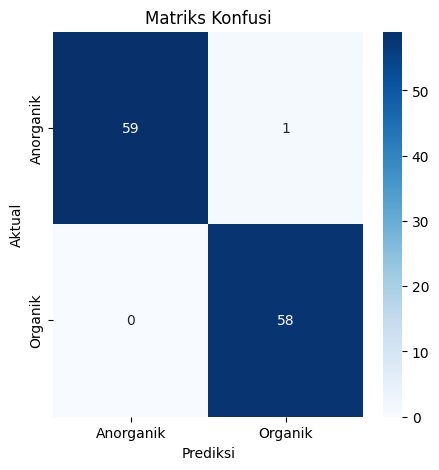

In [30]:
# --- Bagian 8: Evaluasi Model Terbaik pada Test Set ---


# X_test dan y_test sudah dinormalisasi dan di-one-hot encoded
loss, accuracy = fine_tuned_model.evaluate(X_test, y_test, verbose=1)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Jika Anda memiliki metrik tambahan (seperti precision, recall, f1-score)
# Anda bisa menghitungnya di sini.
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # Pastikan seaborn diimpor

# Lakukan prediksi pada test set
y_pred_probs = fine_tuned_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # Kelas prediksi (integer)
y_true_classes = np.argmax(y_test, axis=1)     # Kelas sebenarnya (integer)

# Dekode kelas integer kembali ke nama kelas untuk laporan yang lebih mudah dibaca
decoded_y_true = label_encoder.inverse_transform(y_true_classes)
decoded_y_pred = label_encoder.inverse_transform(y_pred_classes)

print("\nLaporan Klasifikasi pada Test Set:")
# labels=label_encoder.classes_ untuk urutan yang benar di laporan
print(classification_report(decoded_y_true, decoded_y_pred, target_names=label_encoder.classes_))

print("\nMatriks Konfusi pada Test Set:")
cm = confusion_matrix(decoded_y_true, decoded_y_pred, labels=label_encoder.classes_)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Matriks Konfusi')
plt.show()

# Save Final Model

In [31]:
# --- Simpan model terbaik setelah pelatihan ulang ---
MODEL_SAVE_PATH = '../models/klasifikasi_sampah_final_v1.h5' # Format HDF5

fine_tuned_model.save(MODEL_SAVE_PATH)
print(f"\nModel terbaik telah disimpan ke: {MODEL_SAVE_PATH}")

# Contoh cara memuat kembali model:
# loaded_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
# print(f"Model berhasil dimuat kembali. Summary model yang dimuat:")
# loaded_model.summary()


Model terbaik telah disimpan ke: ../models/klasifikasi_sampah_final_v1.h5


In [1]:
import tensorflow as tf

# Ganti 'nama_model_anda.h5' dengan path file model .h5 Anda
model = tf.keras.models.load_model('../models/klasifikasi_sampah_final_v1.h5')

# Tampilkan summary model
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,436 (9.87 MB)

 Trainable params: 2,518,210 (9.61 MB)

 Non-trainable params: 68,224 (266.50 KB)

 Optimizer params: 2 (12.00 B)